In [1]:
import matplotlib.pyplot as plt
import numpy as np
from src.io_utils import load_data
import src.functions as F
import src.viz as V
from src.healthanalyzer import HealthAnalyzer

df = load_data("data/health_study_dataset.csv")

## Beskrivande analys

In [2]:
display(df[["age", "height", "weight", "systolic_bp", "cholesterol"]].describe())

,age,height,weight,systolic_bp,cholesterol
count,800.000000,800.000000,800.000000,800.000000,800.000000
mean,49.426250,171.849250,73.413000,149.178625,4.929150
std,14.501118,9.804259,13.685059,12.793360,0.848413
min,18.000000,144.400000,33.700000,106.800000,2.500000
25%,39.000000,164.775000,64.800000,140.900000,4.327500
50%,50.000000,171.350000,73.200000,149.400000,4.970000
75%,59.000000,178.925000,82.600000,157.600000,5.482500
max,90.000000,200.400000,114.400000,185.900000,7.880000


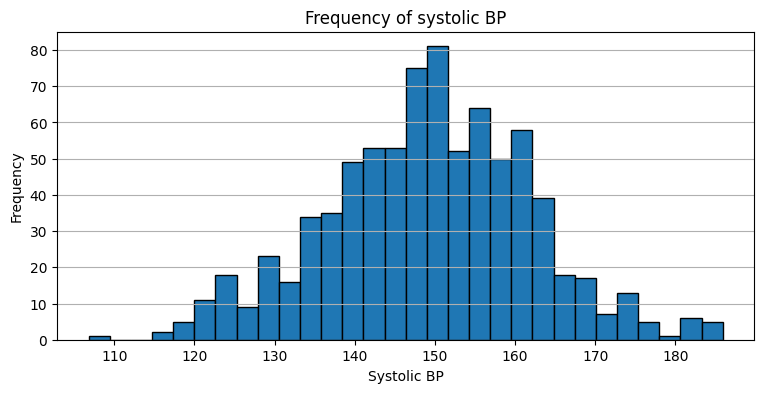

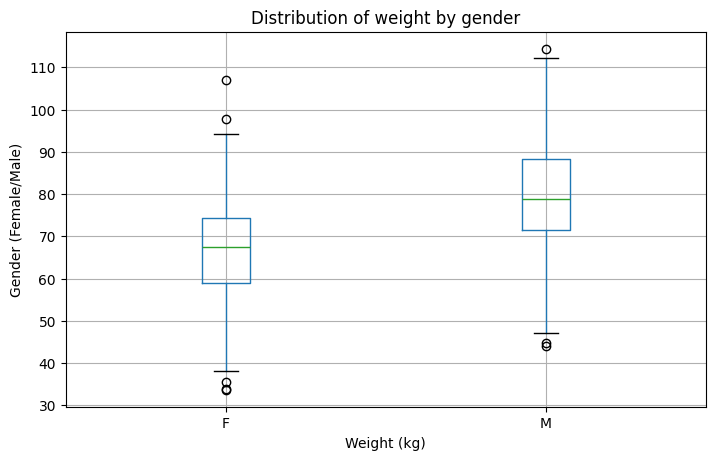

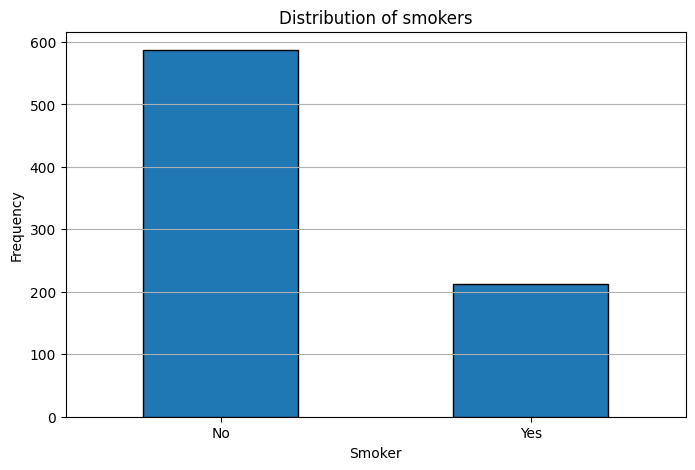

In [3]:
fig, ax = plt.subplots(figsize=(9, 4))
V.plot_hist(ax, df["systolic_bp"], "Frequency of systolic BP", "Systolic BP", "Frequency")
plt.show()

fig, ax = plt.subplots(figsize=(8, 5))
V.boxplot_by_group(ax, df, "weight", "sex", "Distribution of weight by gender", "Weight (kg)", "Gender (Female/Male)")
plt.suptitle("")
plt.show()

fig, ax = plt.subplots(figsize=(8, 5))
V.plot_barchart(ax, df["smoker"], "Distribution of smokers", "Smoker")
plt.xticks(rotation=0)
plt.show()


## Simulering kopplat till caset

In [4]:
F.simulating_proportions(df, ["disease"], 1000)

"
    Proportion of 1 in sample                                   : 0.05875                               
    Simulated proportion of 1 with the sample size of 1000    : 0.056
    


## Konfidensintervall för systoliskt blodtryck
- Valde att göra normalapproximation med hjälp av t-fördelning då populationsstandardavvikelse är okänd.
- Konfidensintervallet blir litet då vi har ett stort stickprov med litet spridning (liten standardavvikelse)
- Uträkning med bootstrap gav ett snävare intervall vilket kan tyda på mer precis uträkning men kan också bero på att bootstrapen underskattar osäkerheten. Normalapproximation är mer konservativ.
- Källa: Business Statistics av Jaggia & Kelly (2021)

In [5]:
low, high = F.conf_intervall(df["systolic_bp"])
low_boot, high_boot = F. ci_mean_bootstrap(df["systolic_bp"])
mean_systolic_bp = df["systolic_bp"].mean()

print(f"""
Mean for systolic BP                : {mean_systolic_bp:.2f}
95% CI with normal approximation    : ({low:.2f}, {high:.2f})
95% CI with bootstrap               : ({low_boot:.2f}, {high_boot:.2f})
""")



Mean for systolic BP                : 149.18
95% CI with normal approximation    : (148.29, 150.07)
95% CI with bootstrap               : (148.30, 150.06)



## Hypotesprövning
H₀: medelvärde för bloodtryck hos rökare = medelvärde för bloodtryck hos icke-rökare    
H₁: medelvärde för bloodtryck hos rökare > medelvärde för bloodtryck hos icke-rökare

- Vi gör ett ensidigt Welch's t-test då varianserna för våra två grupper inte kan antas lika (equal_var=False).
- Vi räknar ut ett konfidensintervall för skillnaden i medelvärden med hjälp av t-fördelningen.
- Källor: Scipy docs: stats.ttest_ind och Business Statistics av Jaggia & Kelly (2021)

In [8]:
from statsmodels.stats.api import DescrStatsW
from statsmodels.stats.api import CompareMeans
from scipy import stats

bp_smoker = df[df["smoker"] == "Yes"]["systolic_bp"]
bp_no_smoker = df[df["smoker"] == "No"]["systolic_bp"]

t_stat, p_value = stats.ttest_ind(bp_smoker, bp_no_smoker, equal_var=False, alternative="greater")
res = CompareMeans(DescrStatsW(bp_smoker), DescrStatsW(bp_no_smoker))
low_ci_diff, high_ci_diff = res.tconfint_diff(alpha=0.05, usevar="unequal")


print(f"""
--- One-sided t-test: systolic BP for smokers > systolic BP fon non-smokers ---
Mean Systolic BP för smokers                : {bp_smoker.mean():.2f}
Mean Systolic BP for non-smokers            : {bp_no_smoker.mean():.2f}
Difference between means                    : {bp_smoker.mean() - bp_no_smoker.mean():.2f}
t-stats                                     : {t_stat:.3f}
p-value (one-sided)                         : {p_value:.3f}
CI 95% for the difference between the means : {low_ci_diff:.3f}, {high_ci_diff:.3f}          
""")



--- One-sided t-test: systolic BP for smokers > systolic BP fon non-smokers ---
Mean Systolic BP för smokers                : 149.52
Mean Systolic BP for non-smokers            : 149.05
Difference between means                    : 0.47
t-stats                                     : 0.450
p-value (one-sided)                         : 0.326
CI 95% for the difference between the means : -1.589, 2.533          



**Tolkning**: 

- p-värdet > 0.05 vilket gör att vi inte kan förkasta nollhypotesen vid signifikansnivå 95%.
- Konfidensintervallet innehåller 0 vilket också visar att vi inte kan förkasta nollhypotesen
- Detta innebär att det **inte finns tillräckligt statistikt stöd** för att rökare har högre medelblodtryck än icke-rökare

## Power

- Valde mellan NormalIndPower() och TTestIndPower(). Den senare används när varianserna är lika eller kan anses lika. Då vi inte har antagit lika varians tidigare väljs istället NormalIndPower() för att beräkna power baserat på normalapproximation. 
- NormIndPower() kan användas när vi har normalfördelad data eller tillräckligt stora stickprov där t-fördelningen nästan är lika med normalfördelningen. Vi har två stickprov med ca 200 respektive 550 observationer vilket kan anses som tillräckligt stora.

- Källa: Statsmodels docs: stats.power.TTestIndPower och stats.power.NormalIndPower
- Källa: Business Statistics av Jaggia & Kelly (2021)

In [9]:
from statsmodels.stats.power import NormalIndPower

mean1 = bp_smoker.mean()
mean2 = bp_no_smoker.mean()
sd1, sd2 = bp_smoker.std(ddof=1), bp_no_smoker.std(ddof=1)
d_welch = (mean1 - mean2) / np.sqrt((sd1**2 + sd2**2) / 2)
alpha = 0.05
n_smoker = len(bp_smoker)
n_no_smoker = len(bp_no_smoker)
ratio = n_no_smoker / n_smoker

solver = NormalIndPower()

power = solver.power(effect_size=d_welch,
                                nobs1=n_smoker,
                                alpha=alpha,
                                ratio=ratio,
                                alternative="two-sided")


print(f"Power (normalapproximation) ≈ {power:.3f}")

Power (normalapproximation) ≈ 0.074


**Tolkning:** Att power blir så lågt (0.074) innebär att sannolikheten att upptäcka verklig skillnad i blodtryck mellan rökare och icke-rökar är **mycket liten** med det aktuella datamaterialet

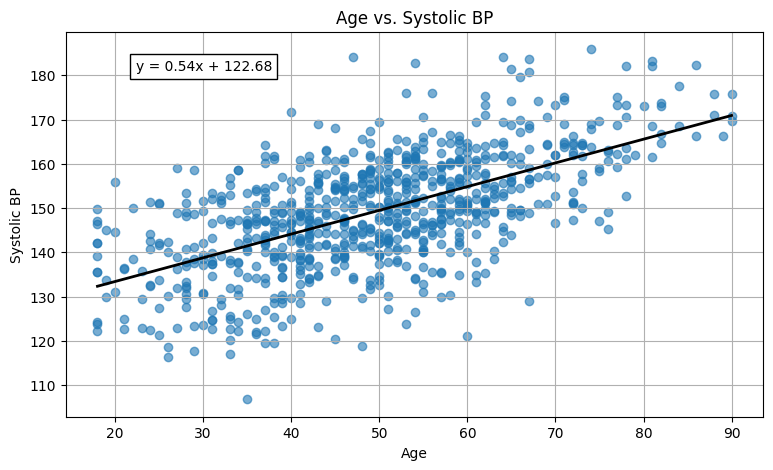

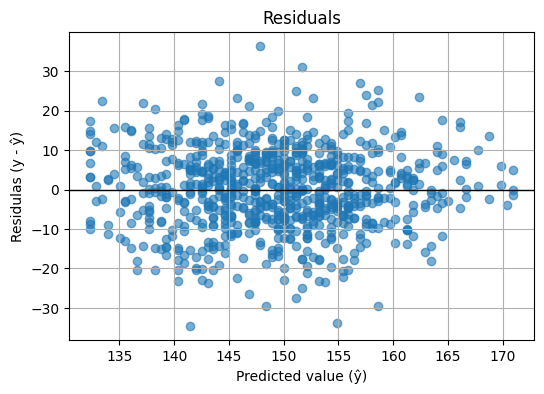


------------ Regression: Age vs. Systolic BP ------------
Intercept   : 122.68
Slope       : 0.54
R²          : 0.369
Predicted systolic BP at age 60 using our regression-model: 154.8
Interpretation slope: +10 years => blood pressure increase by 5.36



In [13]:
intercept_hat, slope_hat, r2, y_hat, residuals = F.regression(df, "age", "systolic_bp")

fig, ax = plt.subplots(figsize=(9, 5))
V.plot_scatter(ax, df["age"], df["systolic_bp"], "Age vs. Systolic BP", "Age", "Systolic BP")
x_line = np.linspace(df["age"].min(), df["age"].max(), 100)
y_line = intercept_hat + slope_hat * x_line
ax.plot(x_line, y_line, color="black", linewidth=2)
textstr = f"y = {slope_hat:.2f}x + {intercept_hat:.2f}"
ax.text(0.1, 0.9, textstr, transform=ax.transAxes, bbox=dict(facecolor='white', edgecolor='black'))
plt.show()

fig, ax = plt.subplots(figsize=(6, 4))
V.plot_scatter(ax, y_hat, residuals, "Residuals", "Predicted value (ŷ)", "Residulas (y - ŷ)")
ax.axhline(0, color="black", linewidth=1)
plt.show()

predicted_y_60 = F.regression_prediction(60, intercept_hat, slope_hat)

print(f"""
------------ Regression: Age vs. Systolic BP ------------
Intercept   : {intercept_hat:.2f}
Slope       : {slope_hat:.2f}
R²          : {r2:.3f}
Predicted systolic BP at age 60 using our regression-model: {predicted_y_60:.1f}
Interpretation slope: +10 years => blood pressure increase by {10*slope_hat:.2f}
""")


**Tolkning:** Baserat på regressionsanalysen ses systoliskt bloodtryck öka med åldern. Det finns en korrelation mellan bloodtryck och åldern dock säger resultaten ingeting om kausalitet. Vårt R²-värde visar att ca 37% av variationen i blodtryck kan förklaras av ålder, modellen har en måttlig förklaringsgrad. Troligtvis finns det också en korrelation mellan blodtryck och genetik, livstil osv. som modellen inte fångar. 

In [ ]:
intercept_hat, slope_hat, _, _, residuals = F.regression(df, "cholesterol", "systolic_bp")
fig, ax = plt.subplots(figsize=(9, 5))
V.plot_scatter(ax, df["cholesterol"], df["systolic_bp"], "Cholesterol vs. Systolic BP", "Cholesterol", "Systolic BP")
x_line = np.linspace(df["cholesterol"].min(), df["cholesterol"].max(), 20)
y_line = intercept_hat + slope_hat * x_line
ax.plot(x_line, y_line, color="black", linewidth=2)
textstr = f"y = {slope_hat:.2f}x + {intercept_hat:.2f}"
ax.text(0.1, 0.9, textstr, transform=ax.transAxes, bbox=dict(facecolor='white', edgecolor='black'))
plt.show()

In [ ]:
analyzer = HealthAnalyzer(df)

analyzer.summary_data(["age"])